In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import sin, cos, pi
import cv2
import pickle

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, ReLU, GlobalAveragePooling2D, Dropout, Dense, Activation
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/training.zip" -d "/content"
!unzip "/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/test.zip" -d "/content"

Archive:  /content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/training.zip
  inflating: /content/training.csv   
Archive:  /content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/test.zip
  inflating: /content/test.csv       


In [ ]:
train_data = pd.read_csv('/content/training.csv')
test_file = pd.read_csv('/content/test.csv')
idlookup_file = pd.read_csv('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/IdLookupTable.csv')

In [ ]:
idlookup_file.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [ ]:
train_data.isnull().sum() * 100 / len(train_data)

left_eye_center_x             0.141864
left_eye_center_y             0.141864
right_eye_center_x            0.184423
right_eye_center_y            0.184423
left_eye_inner_corner_x      67.782664
left_eye_inner_corner_y      67.782664
left_eye_outer_corner_x      67.839410
left_eye_outer_corner_y      67.839410
right_eye_inner_corner_x     67.825223
right_eye_inner_corner_y     67.825223
right_eye_outer_corner_x     67.825223
right_eye_outer_corner_y     67.825223
left_eyebrow_inner_end_x     67.796851
left_eyebrow_inner_end_y     67.796851
left_eyebrow_outer_end_x     68.435239
left_eyebrow_outer_end_y     68.435239
right_eyebrow_inner_end_x    67.796851
right_eyebrow_inner_end_y    67.796851
right_eyebrow_outer_end_x    68.279189
right_eyebrow_outer_end_y    68.279189
nose_tip_x                    0.000000
nose_tip_y                    0.000000
mouth_left_corner_x          67.811037
mouth_left_corner_y          67.811037
mouth_right_corner_x         67.796851
mouth_right_corner_y     

In [ ]:
clean_train_file = train_data.dropna()
train_data = train_data.fillna(method='ffill')

In [ ]:
test_images.shape

(1783, 96, 96, 1)

In [136]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], c='red', marker='x', s=20)
    plt.title(title)

In [70]:
def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop(['Image'], axis=1)
    keypoint_features = []
    for idx, features in keypoint_data.iterrows():
        keypoint_features.append(features)
    keypoint_features = np.array(keypoint_features, dtype=float)
    return keypoint_features

train_images = load_images(train_data)
images = load_images(clean_train_file) #without missing values 
train_keypoints = load_keypoints(train_data)
keypoints = load_keypoints(clean_train_file)
test_images = load_images(test_file)

In [ ]:
train_images.shape, train_keypoints.shape

((7049, 96, 96, 1), (7049, 30))

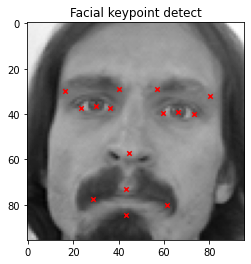

In [137]:
fig, axis = plt.subplots()
plot_sample(images[0], keypoints[0], axis, "Facial keypoint detect")

## Image Augmentation

In [ ]:
rotation_augmentation = True
random_noise_augmentation = True
brightness_augmentation = True
rotation_angles = [20]
center_of_image = (48, 48) #height/2, width/2 to get the center of image

## Rotation

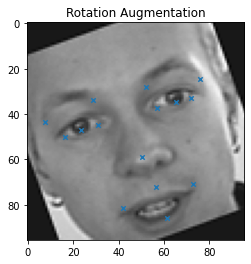

In [82]:
def rotate_augmentation(images, keypoints, rotation_angles):
    rotated_images = []
    rotated_keypoints = []
    for angle in rotation_angles:
        for angle in [angle, -angle]:
            M = cv2.getRotationMatrix2D((48,48), angle, 1.)
            angle_rad = -angle*pi/180.
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.
                for idx in range(0, len(rotated_keypoint), 2):
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

if rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(images, keypoints, rotation_angles)
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[19], rotated_train_keypoints[19], axis, "Rotation Augmentation")

In [ ]:
train_images.shape, train_keypoints.shape

((11329, 96, 96, 1), (11329, 30))

## Add noise

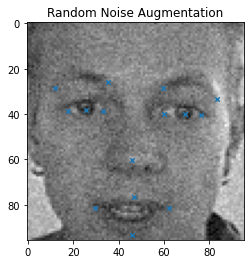

In [83]:
def add_noise(images):
    noisy_images = []
    for image in images:
        row,col,ch= image.shape
        mean = 0
        var = 0.01
        sigma = var**0.6
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        noisy_images.append(noisy.reshape(96,96,1))
    return np.reshape(noisy_images,(-1,96,96,1))

if random_noise_augmentation:
    noisy_train_images = add_noise(images)
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, keypoints))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[19], keypoints[19], axis, "Random Noise Augmentation")

In [ ]:
train_images.shape, train_keypoints.shape

((13469, 96, 96, 1), (13469, 30))

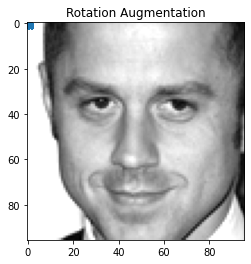

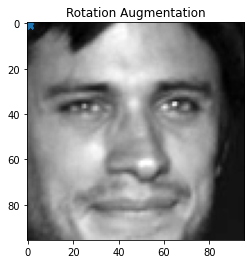

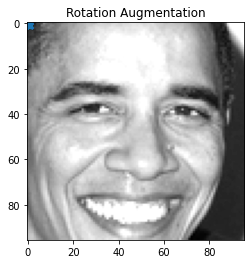

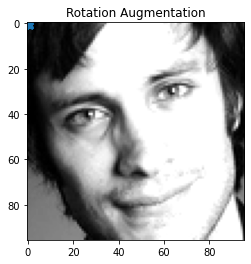

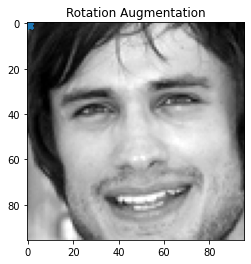

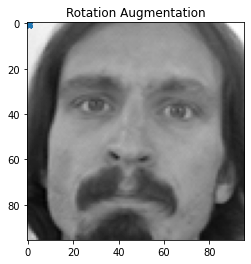

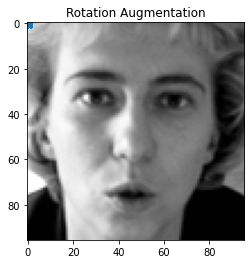

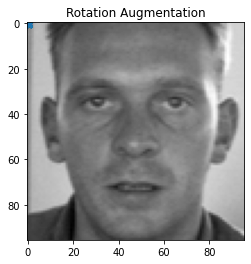

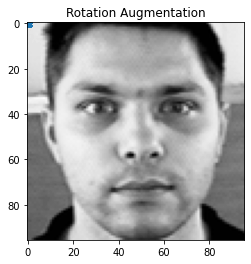

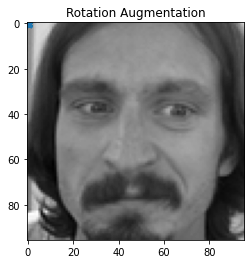

In [ ]:

for i in range(2135,2145):
  fig, axis = plt.subplots()
  plot_sample(altered_brightness_images[i], altered_brightness_images[i], axis, "Rotation Augmentation")

## Brightness

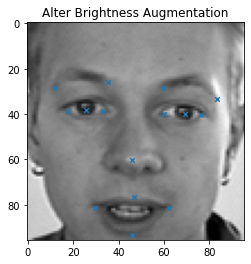

In [84]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.5, 0.0, 1.0)    
    dec_brightness_images = np.clip(images*0.5, 0.0, 1.0)    
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

if brightness_augmentation:
    altered_brightness_images, altered_brightness_keypoints = alter_brightness(images, keypoints)
    train_images = np.concatenate((train_images, altered_brightness_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_images[2159], altered_brightness_keypoints[2159], axis, "Alter Brightness Augmentation")

## Pretrained resnet50 with finetuning - compile

In [71]:
model = Sequential()
pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model.add(Conv2D(3, (1,1), padding='same', input_shape=(96,96,1)))
model.add(Activation('ReLU'))
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 activation_3 (Activation)   (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 30)                61470     
                                                      

## Pretrained resnet50 with fine tuning - fitting

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=20, mode='min',
                             baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-10, mode='min', verbose=1)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(train_images, train_keypoints, epochs=200, batch_size=64, validation_split=0.15, callbacks=[earlyStopping, rlp])

Epoch 1/200
94/94 [==============================] - 23s 108ms/step - loss: 254.2912 - root_mean_squared_error: 15.9465 - val_loss: 21.7101 - val_root_mean_squared_error: 4.6594 - lr: 0.0010
Epoch 2/200
94/94 [==============================] - 9s 92ms/step - loss: 8.1763 - root_mean_squared_error: 2.8594 - val_loss: 91.9850 - val_root_mean_squared_error: 9.5909 - lr: 0.0010
Epoch 3/200
94/94 [==============================] - 9s 92ms/step - loss: 6.0537 - root_mean_squared_error: 2.4604 - val_loss: 55.3522 - val_root_mean_squared_error: 7.4399 - lr: 0.0010
Epoch 4/200
94/94 [==============================] - ETA: 0s - loss: 4.8160 - root_mean_squared_error: 2.1945
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
94/94 [==============================] - 9s 92ms/step - loss: 4.8160 - root_mean_squared_error: 2.1945 - val_loss: 97.4266 - val_root_mean_squared_error: 9.8705 - lr: 0.0010
Epoch 5/200
94/94 [==============================] - 9s 92ms/step - loss:

## Save model (resnet50) history

In [ ]:
with open('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/resnet_history_wo_aug', 'wb') as file_pk:
    pickle.dump(history.history, file_pk)

## Save model (resnet50)

In [ ]:
model.save('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/resnet_wo_aug')

INFO:tensorflow:Assets written to: /content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/resnet_wo_aug/assets


INFO:tensorflow:Assets written to: /content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/resnet_wo_aug/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
#new_model = load_model('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/resnet_pretrained')
#new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 activation_1 (Activation)   (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 30)                61470     
                                                      

## Pretrained densenet121 with finetuning - compile

In [85]:
model = Sequential()
pretrained_model = DenseNet121(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model.add(Conv2D(3, (1,1), padding='same', input_shape=(96,96,1)))
model.add(Activation('ReLU'))
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 activation_5 (Activation)   (None, 96, 96, 3)         0         
                                                                 
 densenet121 (Functional)    (None, 3, 3, 1024)        7037504   
                                                                 
 global_average_pooling2d_5   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 30)                30750     
                                                      

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=(96,96,1)))
model.add(Activation('ReLU'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('ReLU'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 96, 96, 32)        320       
                                                                 
 activation_10 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 activation_11 (Activation)  (None, 96, 96, 64)        0         
                                                                 
 global_average_pooling2d_10  (None, 64)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                     

## Pretrained densenet121 with fine tuning - fitting

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-15, mode='min', verbose=1)

model.compile(optimizer='adam', loss='mean_squared_error')

history_dense = model.fit(train_images, train_keypoints, epochs=200, batch_size=64, validation_split=0.15, callbacks=[earlyStopping, rlp])

Epoch 1/200
94/94 [==============================] - 24s 133ms/step - loss: 971.7444 - val_loss: 478.3079 - lr: 0.0010
Epoch 2/200
94/94 [==============================] - 10s 102ms/step - loss: 27.9129 - val_loss: 79.8828 - lr: 0.0010
Epoch 3/200
94/94 [==============================] - 10s 102ms/step - loss: 10.9775 - val_loss: 35.7810 - lr: 0.0010
Epoch 4/200
94/94 [==============================] - 10s 102ms/step - loss: 10.0434 - val_loss: 13.3975 - lr: 0.0010
Epoch 5/200
94/94 [==============================] - 10s 102ms/step - loss: 9.3229 - val_loss: 12.3804 - lr: 0.0010
Epoch 6/200
94/94 [==============================] - 10s 102ms/step - loss: 8.4467 - val_loss: 11.1990 - lr: 0.0010
Epoch 7/200
94/94 [==============================] - 10s 102ms/step - loss: 7.7985 - val_loss: 8.3202 - lr: 0.0010
Epoch 8/200
94/94 [==============================] - 10s 102ms/step - loss: 7.1399 - val_loss: 8.9735 - lr: 0.0010
Epoch 9/200
94/94 [==============================] - 10s 102ms/step 

In [ ]:
with open('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/densenet_hist_wo_aug', 'wb') as file_pk:
    pickle.dump(history_dense.history, file_pk)

In [ ]:
model.save('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/densenet_wo_aug')

INFO:tensorflow:Assets written to: /content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/densenet_wo_aug/assets


INFO:tensorflow:Assets written to: /content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/densenet_wo_aug/assets


In [ ]:
resnet_finetuned_model = load_model('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/resnet_pretrained')
resnet_finetuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 activation_1 (Activation)   (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 30)                61470     
                                                      

## MSE loss

In [109]:
eps_min = 1e-8

def mse_loss(label, pred):
    squared_difference = tf.square((label - pred))
    mse = tf.reduce_mean(squared_difference, axis=-1)
    return mse

def add_loss(label, pred):
    return mse_loss(label, pred) + 0.01*cgd_loss(label, pred)


In [ ]:
def kl_loss(label, predict):
    kl = tf.reduce_sum(label * tf.clip_by_value(tf.math.log(label/(predict+eps_min)), eps_min, eps_max))
    return kl

## CGD loss

In [110]:


def pairwise_dist (A, B):  
  """
  Computes pairwise distances between each elements of A and each elements of B.
  Args:
    A,    [m,d] matrix
    B,    [n,d] matrix
  Returns:
    D,    [m,n] matrix of pairwise distances
  """

  # squared norms of each row in A and B
  na = tf.reduce_sum(tf.square(A), 1)
  nb = tf.reduce_sum(tf.square(B), 1)
    
  # na as a row and nb as a co"lumn vectors
  na = tf.reshape(na, [-1, 1])
  nb = tf.reshape(nb, [1, -1])

  # return pairwise euclidean difference matrix
  D = tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0)+eps_min)
   
  return D


def cgd_loss(label, pred):

    '''
    evens = tf.range(0, pred.get_shape()[1]*batch_size, 2)
    odds = tf.range(1, pred.get_shape()[1]*batch_size, 2)
    '''
    
    #Split into two subset of corners: left curve and right curve
    #print(evens.get_shape(), odds.get_shape(), pred.get_shape())

    A_pred = tf.reshape(pred, [-1,2])    
    A_label = tf.reshape(label, [-1,2])
   


    #print(A_pred.get_shape())
    #Calculate distances as in a bipartite graph
    D_pred = pairwise_dist(A_pred, A_pred)
    D_label = pairwise_dist(A_label, A_label) 
    
    #print(D_pred.get_shape(), D_label.get_shape())
    #either mean or sum could be taken
    cgd = tf.reduce_sum(tf.abs(tf.subtract(D_label, D_pred)+eps_min))
    
    return cgd

def bpd_loss(label, pred):

    evens = tf.range(0, pred.get_shape()[1], 2)
    odds = tf.range(1, pred.get_shape()[1], 2)

    
    #Split into two subset of corners: left curve and right curve
    #print(evens.get_shape(), odds.get_shape(), pred.get_shape())

    A_pred = tf.gather(tf.reshape(pred, [-1,2]), evens)
    B_pred = tf.gather(tf.reshape(pred, [-1,2]), odds)    
    A_label = tf.gather(tf.reshape(label, [-1,2]), evens)
    B_label = tf.gather(tf.reshape(label, [-1,2]), odds)


    #print(A_pred.get_shape())
    #Calculate distances as in a bipartite graph
    D_pred = pairwise_dist(A_pred, B_pred)
    D_label = pairwise_dist(A_label, B_label)
    
    #print(D_pred.get_shape(), D_label.get_shape())
    #either mean or sum could be taken
    bpd = tf.reduce_mean(tf.abs(tf.subtract(D_label, D_pred)+eps_min))

    '''diff = evens[:4] - odds[:4]
    bpd = tf.reduce_sum(tf.abs(diff))  '''   
    
    return bpd

In [ ]:
t = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tf.reshape(t, [-1,2])

<tf.Tensor: shape=(5, 2), dtype=int32, numpy=
array([[ 1,  2],
       [ 3,  4],
       [ 5,  6],
       [ 7,  8],
       [ 9, 10]], dtype=int32)>

## resnet with CGD loss - fitting

In [86]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

model.compile(optimizer='adam', loss=add_loss, metrics=['mse'])

history_dense = model.fit(train_images, train_keypoints, epochs=200, batch_size=64, validation_split=0.15, callbacks=[earlyStopping, rlp])

Epoch 1/200
236/236 [==============================] - 38s 117ms/step - loss: 72948.7500 - mse: 2362.1338 - val_loss: 57089.4375 - val_mse: 2057.9915 - lr: 0.0010
Epoch 2/200
236/236 [==============================] - 25s 105ms/step - loss: 20951.3613 - mse: 1955.7002 - val_loss: 38886.4492 - val_mse: 1788.0364 - lr: 0.0010
Epoch 3/200
236/236 [==============================] - 25s 104ms/step - loss: 17379.5840 - mse: 1726.7997 - val_loss: 30444.1543 - val_mse: 1612.7770 - lr: 0.0010
Epoch 4/200
236/236 [==============================] - 24s 103ms/step - loss: 16075.6826 - mse: 1556.1704 - val_loss: 21601.9512 - val_mse: 1488.9410 - lr: 0.0010
Epoch 5/200
236/236 [==============================] - 24s 103ms/step - loss: 14998.4004 - mse: 1425.7207 - val_loss: 26099.1875 - val_mse: 1367.8275 - lr: 0.0010
Epoch 6/200
236/236 [==============================] - 24s 103ms/step - loss: 14570.2803 - mse: 1322.2035 - val_loss: 16793.1875 - val_mse: 1307.4698 - lr: 0.0010
Epoch 7/200
236/236 [=

In [87]:
with open('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/densenet_history_w_aug_CGD', 'wb') as file_pk:
    pickle.dump(history_dense.history, file_pk)

In [88]:
model.save('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/densenet_w_aug_CGD')

INFO:tensorflow:Assets written to: /content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/densenet_w_aug_CGD/assets


INFO:tensorflow:Assets written to: /content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/densenet_w_aug_CGD/assets


### Plot loss 

In [91]:
with open("/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/densenet_history_w_aug_CGD", "rb") as input_file:
  e = pickle.load(input_file)



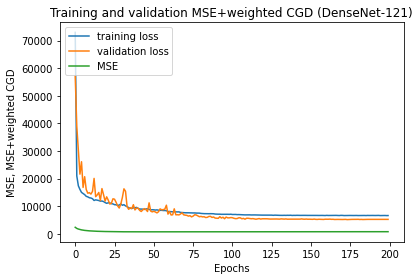

In [92]:
loss_image = "cgd_densenet_w_aug.png"

plt.plot(e['loss'])
plt.plot(e['val_loss'])
plt.plot(e['mse'])
plt.legend(['training loss', 'validation loss', 'MSE'], loc = 'upper left')
plt.title('Training and validation MSE+weighted CGD (DenseNet-121)')
plt.xlabel('Epochs')
plt.ylabel('MSE, MSE+weighted CGD')
plt.tight_layout()
plt.savefig("/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/"+loss_image, dpi=150)

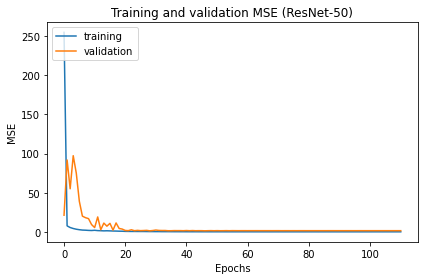

In [134]:
loaded_model = load_model("/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/densenet_w_aug_CGD", compile=False)
loaded_model.compile(optimizer='adam', loss=add_loss, metrics=['mse'])
pred_keypoints = loaded_model.predict(test_images)

In [96]:
feature_names = list(idlookup_file['FeatureName'])
imageIDs = list(idlookup_file['ImageId']-1)
len(imageIDs)

27124

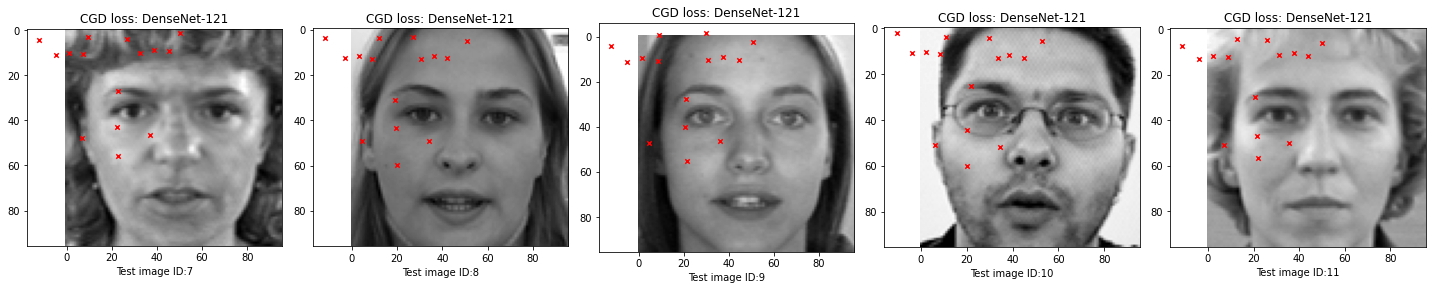

In [135]:
def plot_img(image, keypoint, title):
    image = image.reshape(96,96)
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoint[0::2], keypoint[1::2], c='red', marker='x', s=20)
    plt.title(title)

a = 1  # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter

s = 7
e = 12

test_pred_name = 'densenet_cgd_test.png'

fig = plt.figure(figsize=(20,20))

for i in range(s,e):
    fig.add_subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel('Test image ID:' + str(i))
    plot_img(test_images[i], pred_keypoints[i], "CGD loss: DenseNet-121")
    c = c + 1

plt.tight_layout()
fig.savefig("/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Project/"+test_pred_name, dpi=150, bbox_inches='tight')

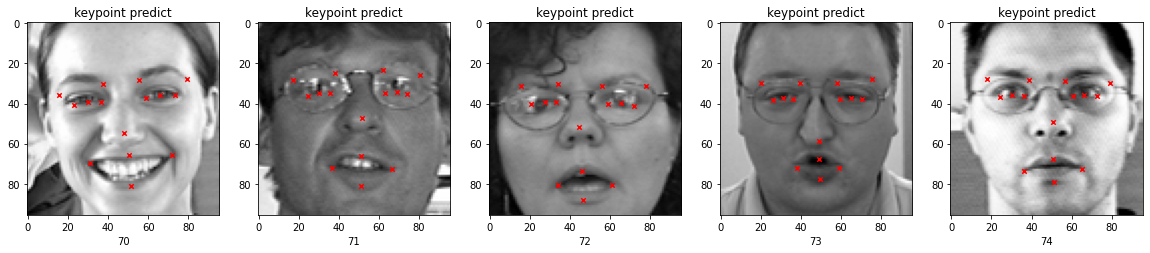

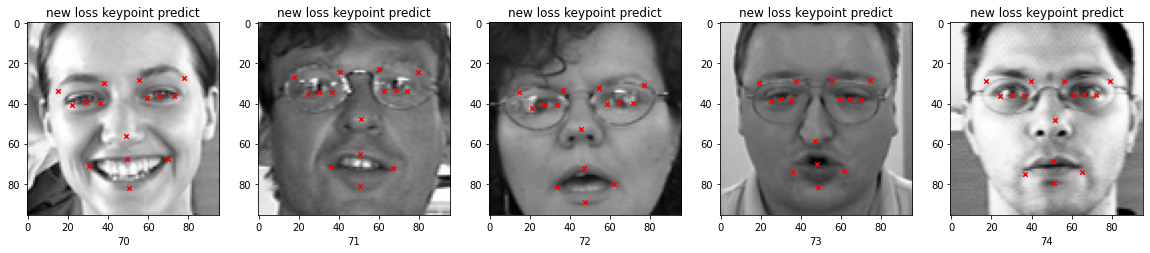

In [ ]:
a = 1  # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(20,20))

s = 70
e = 75

for i in range(s,e):
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    plot_img(test_images[i], pred_keypoints[i], "keypoint predict")
    c = c + 1

plt.show()

a = 1  # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(20,20))

for i in range(s,e):
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    plot_img(test_images[i], cur_pred_keypoints[i], "new loss keypoint predict")
    c = c + 1

plt.show()

In [ ]:
feature_index = []
for feature in feature_names:
    feature_index.append(feature_names.index(feature))

In [ ]:
idlookup_file.ImageId

0           1
1           1
2           1
3           1
4           1
         ... 
27119    1783
27120    1783
27121    1783
27122    1783
27123    1783
Name: ImageId, Length: 27124, dtype: int64

In [ ]:
pred_image_keypoint = []
for x,y in zip(imageIDs,feature_index):
    pred_image_keypoint.append(pred_keypoints[x][y])
pred_image_keypoint_array = np.array(pred_image_keypoint)


In [ ]:
feature_names[:30]

['left_eye_center_x',
 'left_eye_center_y',
 'right_eye_center_x',
 'right_eye_center_y',
 'left_eye_inner_corner_x',
 'left_eye_inner_corner_y',
 'left_eye_outer_corner_x',
 'left_eye_outer_corner_y',
 'right_eye_inner_corner_x',
 'right_eye_inner_corner_y',
 'right_eye_outer_corner_x',
 'right_eye_outer_corner_y',
 'left_eyebrow_inner_end_x',
 'left_eyebrow_inner_end_y',
 'left_eyebrow_outer_end_x',
 'left_eyebrow_outer_end_y',
 'right_eyebrow_inner_end_x',
 'right_eyebrow_inner_end_y',
 'right_eyebrow_outer_end_x',
 'right_eyebrow_outer_end_y',
 'nose_tip_x',
 'nose_tip_y',
 'mouth_left_corner_x',
 'mouth_left_corner_y',
 'mouth_right_corner_x',
 'mouth_right_corner_y',
 'mouth_center_top_lip_x',
 'mouth_center_top_lip_y',
 'mouth_center_bottom_lip_x',
 'mouth_center_bottom_lip_y']

In [ ]:
test_images[0]

array([[[0.71372549],
        [0.71764706],
        [0.71372549],
        ...,
        [0.71372549],
        [0.71372549],
        [0.71372549]],

       [[0.71372549],
        [0.70980392],
        [0.70980392],
        ...,
        [0.71372549],
        [0.71372549],
        [0.71372549]],

       [[0.71372549],
        [0.70980392],
        [0.70588235],
        ...,
        [0.71372549],
        [0.70980392],
        [0.71372549]],

       ...,

       [[0.16470588],
        [0.14117647],
        [0.07843137],
        ...,
        [0.49411765],
        [0.53333333],
        [0.6       ]],

       [[0.12156863],
        [0.03137255],
        [0.        ],
        ...,
        [0.03529412],
        [0.04313725],
        [0.12941176]],

       [[0.01176471],
        [0.        ],
        [0.00392157],
        ...,
        [0.03137255],
        [0.01960784],
        [0.01960784]]])